# <center> Sistema de Recomendaciones

#####  Carga de Datos Movie Lens
##### http://files.grouplens.org/datasets/movielens/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
data = pd.read_csv("../datasets/ml-100k/u.data.csv")
data.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Análisi exploratorio de los ítems

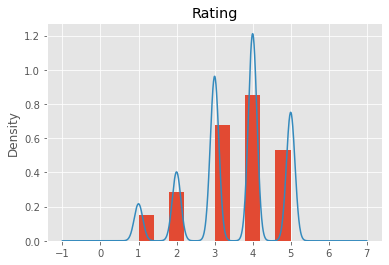

In [3]:
plt.hist(data.Rating,density=True)
data["Rating"].plot(kind = "kde")
plt.title("Rating")
plt.show()

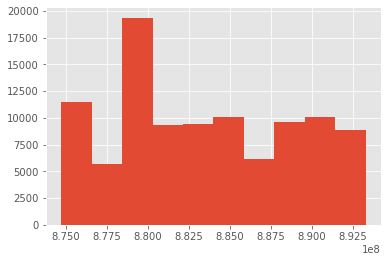

In [4]:
plt.hist(data.TimeStamp)
plt.show()

In [5]:
data.groupby(["Rating"]).describe()

UserID                                                           \
          count        mean         std  min    25%    50%    75%    max   
Rating                                                                     
1        6110.0  433.439771  263.367606  1.0  206.0  405.0  648.0  943.0   
2       11370.0  472.553298  267.325575  1.0  255.0  454.0  698.0  943.0   
3       27145.0  473.030061  263.417504  1.0  269.0  456.0  690.0  943.0   
4       34174.0  464.684175  266.010865  1.0  264.0  450.0  682.0  943.0   
5       21201.0  448.408518  270.981157  1.0  236.0  420.0  671.0  943.0   

         ItemID              ...                TimeStamp                \
          count        mean  ...    75%     max     count          mean   
Rating                       ...                                          
1        6110.0  576.474959  ...  876.0  1678.0    6110.0  8.836804e+08   
2       11370.0  503.634477  ...  756.0  1680.0   11370.0  8.837664e+08   
3       27145.0  457.358077  ...  684.0  1682.0   27145.0  8.835474e+08   
4       34174.0  395.132615  ...  568.0  1674.0   34174.0  8.833652e+08   
5       21201.0  348.388284  ...  499.0  1656.0   21201.0  8.835978e+08   

                                                                            \
                 std          min           25%          50%           75%   
Rating                                                                       
1       5.119870e+06  874729935.0  8.794342e+08  883799947.5  8.880693e+08   
2       5.307663e+06  874728168.0  8.794650e+08  883599971.0  8.885163e+08   
3       5.333161e+06  874724905.0  8.794553e+08  882903645.0  8.882675e+08   
4       5.327826e+06  874724710.0  8.794427e+08  882535666.0  8.880667e+08   
5       5.457200e+06  874725485.0  8.794551e+08  882607356.0  8.886321e+08   

                     
                max  
Rating               
1       893286511.0  
2       893286511.0  
3       893286638.0  
4       893286638.0  
5       893286637.0  

[5 rows x 24 columns]

In [6]:
len(data.UserID.unique())

943

In [7]:
data.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

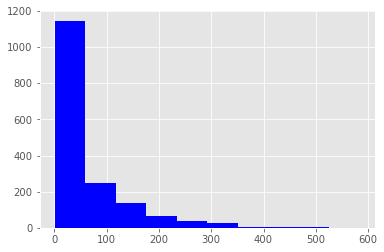

In [8]:
plt.hist(data.groupby(["ItemID"])["UserID"].count(),color = "b")
plt.show()

## Representación en forma matricial

In [9]:
n_user = len(data.UserID.unique())

In [10]:
n_items = len(data.ItemID.unique())

In [11]:
raings = np.zeros((n_user,n_items))

In [12]:
df = pd.DataFrame({"col1":[1,2],"col2":[0.1,0.2]}, index = ["a","b"])
df

,col1,col2
a,1,0.1
b,2,0.2


In [13]:
for k in df.itertuples():
    print(k)

Pandas(Index='a', col1=1, col2=0.1)
Pandas(Index='b', col1=2, col2=0.2)


In [14]:
d = 0
for k in data.itertuples():
    print(k)
    d +=1
    if d==3:
        print(type(k))
        break

Pandas(Index=0, UserID=196, ItemID=242, Rating=3, TimeStamp=881250949)
Pandas(Index=1, UserID=186, ItemID=302, Rating=3, TimeStamp=891717742)
Pandas(Index=2, UserID=22, ItemID=377, Rating=1, TimeStamp=878887116)
<class 'pandas.core.frame.Pandas'>


In [15]:
n_items, data["ItemID"].min(),data["ItemID"].max()

(1682, 1, 1682)

In [16]:
ratings = np.zeros((n_user,n_items))
for row in data.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [17]:
ratings.shape

(943, 1682)

In [18]:
print(ratings.nonzero()[0].max())
ratings.nonzero()[1].max()

942


1681

In [19]:
np.nonzero([[1,2,0],[4,5,6]]) # Arriba row y abajo column

(array([0, 0, 1, 1, 1], dtype=int64), array([0, 1, 0, 1, 2], dtype=int64))

In [20]:
np.nonzero([[1,2,0],[4,5,6],[5,5,5]]) # Arriba row y abajo column

(array([0, 0, 1, 1, 1, 2, 2, 2], dtype=int64),
 array([0, 1, 0, 1, 2, 0, 1, 2], dtype=int64))

In [21]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de Sparsidad : {:4.2f}%".format(sparsity))
# No se conoce casi el 94% de los usuarios-películas. Pudieran 
# haberla no visto. Por lo tamto, se puede recomendar mucho.

Coeficiente de Sparsidad : 6.30%


## Crear conjuntos de entrenamiento y validación

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
ratings_training,ratings_test = train_test_split(ratings,test_size = 0.3)
ratings_training.shape

(660, 1682)

## Filtro Colaborativo basado en Usuarios

- Matriz de Similaridad entre los usuaios (Distancia del Coseno).
- Predecir la valoración desconocida de un ítem i para un usuario activo u, basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
- Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [24]:
import sklearn

In [25]:
?sklearn.metrics.pairwise.cosine_distances
# Compute cosine distance between samples in X and Y.

# Cosine distance is defined as 1.0 minus the cosine similarity.

$$\text{Similarity} = \cos{\theta} = \frac{A\cdot B}{||A||\ ||B||} = \frac{\sum_{i = 1}^n A_iB_i}{\sqrt{\sum_{i = 1}^n A_i^2} \sqrt{\sum_{i = 1}^n B_i^2}}$$

In [26]:
np.sum(ratings_training[0]*ratings_training[1])/(np.linalg.norm(ratings_training[0])*np.linalg.norm(ratings_training[1]))

0.30461533446729383

In [27]:
# Un coseno = 0  me indica que es la distancia es nula y los usuarios son los más parecidos posibles.
# distancia y similaridad son conceptos antepuestos
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_training)
sim_matrix

array([[1.        , 0.30461533, 0.02554845, ..., 0.38503272, 0.34119895,
        0.13295634],
       [0.30461533, 1.        , 0.00424408, ..., 0.27226578, 0.36379488,
        0.23852042],
       [0.02554845, 0.00424408, 1.        , ..., 0.        , 0.04908877,
        0.02477276],
       ...,
       [0.38503272, 0.27226578, 0.        , ..., 1.        , 0.34321421,
        0.37720745],
       [0.34119895, 0.36379488, 0.04908877, ..., 0.34321421, 1.        ,
        0.20061556],
       [0.13295634, 0.23852042, 0.02477276, ..., 0.37720745, 0.20061556,
        1.        ]])

In [28]:
sim_matrix.shape, ratings_training.shape

((660, 660), (660, 1682))

In [29]:
np.array([[1,2,3],[4,5,6]]).dot([[1,2],[4,5],[6,7]]),1*1+2*4+3*6

(array([[27, 33],
        [60, 75]]), 27)

In [30]:
dot_product = sim_matrix.dot(ratings_training) # Se hace una mult. como arriba
users_prediction = dot_product/(np.array([np.abs(sim_matrix).sum(axis=1)])).T

In [31]:
sim_matrix[0].dot(ratings_training[:,0]),dot_product[0,0]

(306.28850337015285, 306.28850337015274)

In [32]:
# Valoración que aproximadamente cada usuario le daría al ítem
users_prediction

array([[2.45971300e+00, 6.70787917e-01, 4.12038234e-01, ...,
        6.41839881e-04, 8.95098323e-03, 7.80558761e-03],
       [2.46985003e+00, 7.14198364e-01, 4.42818314e-01, ...,
        5.59416304e-04, 8.85599605e-03, 7.48921315e-03],
       [1.14286345e+00, 2.09137217e-01, 1.94137875e-01, ...,
        1.13247176e-02, 2.51203912e-03, 8.42443173e-04],
       ...,
       [2.50949139e+00, 7.81538213e-01, 4.35196287e-01, ...,
        3.52010202e-05, 1.05367332e-02, 9.58373366e-03],
       [2.41446286e+00, 7.34063555e-01, 4.32210157e-01, ...,
        4.00865276e-04, 9.04087743e-03, 9.51639586e-03],
       [2.51795502e+00, 8.82523124e-01, 4.95932511e-01, ...,
        6.41196568e-04, 1.07834134e-02, 9.24137588e-03]])

In [33]:
np.max(users_prediction)

4.025636393110599

In [34]:
# Utilizaremos el error cuadrático media para determinar la efectividad de nuestro modelo
# Lo haremos solo a los valores que conocíamos para ver la efectivida de nuestro modelo
from sklearn.metrics import mean_squared_error

In [35]:
def get_mse(preds,actuals):
    if preds.shape[0] == actuals.shape[0]:
        actuals=actuals
    elif preds.shape[0] == actuals.shape[1]:
        actuals = actuals.T
    elif preds.shape[1] == actuals.shape[0]:
        preds = preds.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds,actuals)

In [36]:
users_prediction.shape, ratings_test.shape

((660, 1682), (283, 1682))

In [37]:
get_mse(users_prediction,ratings_training)

7.791310269959328

In [38]:
get_mse(users_prediction,ratings_test)

8.8956755164949

## Filtro Colaborativo Basado en los KNN

In [39]:
from sklearn.neighbors import NearestNeighbors

In [40]:
k = 5
neighbors = NearestNeighbors(k, "cosine")
# ['cityblock', 'cosine', 'euclidean', 'l1', 'l2','manhattan']

In [41]:
neighbors.fit(ratings_training)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [42]:
?neighbors.kneighbors
# Finds the K-neighbors of a point.
# Returns indices of and distances to the neighbors of each point.

In [43]:
ratings_training.shape

(660, 1682)

In [44]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_training, 
                                                   return_distance=True)

In [45]:
top_k_users.shape, top_k_distances.shape

((660, 5), (660, 5))

In [46]:
top_k_distances[0] # Top 5 de distancias entre cada usuario y su top 5 respectivo (k vecinos)

array([ 0.        , 34.55430509, 36.15245497, 36.29049462, 36.4280112 ])

In [47]:
top_k_users[0] # Los usuaios k que más se parecen

array([  0, 316, 599, 396,  93], dtype=int64)

In [48]:
users_predict_k = np.zeros(ratings_training.shape)

In [49]:
for i in range(ratings_training.shape[0]): # Para cada usuario del conjunto de Entrenamiento
    users_predict_k[i,:] = (top_k_distances[i].T.dot(ratings_training[top_k_users[k]]))/np.array([np.abs(top_k_distances[i].T).sum(axis = 0)]).T
    #Volvemos a tener la valoración que cada usuario le daría a las pelís basandonos en los ítems

In [50]:
top_k_distances[0]

array([ 0.        , 34.55430509, 36.15245497, 36.29049462, 36.4280112 ])

In [51]:
users_predict_k

array([[0.75619427, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75023495, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76080913, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.75108523, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75000003, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75945804, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [52]:
get_mse(users_predict_k, ratings_training)

11.497910576213686

In [53]:
get_mse(users_predict_k, ratings_test)

11.31486558108673

##### Hasta ahora hemos buscado similitudes a partir de la similaridad de usuarios. Ahora será a partir de películas

# Filtro Colaborativo basado en Ítems

In [54]:
n_movies = ratings_training.shape[1] # Número de películas
n_movies

1682

In [55]:
neighbors = NearestNeighbors(n_movies, "cosine")
neighbors

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [56]:
neighbors.fit(ratings_training.T) # Trasponemos la matriz para que me queden las pelís en el índice

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [57]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_training.T, return_distance=True)

In [58]:
top_k_distances.shape, top_k_items.shape # Obtuvimos todas las similitudes 
# de todos los usuarios.

((1682, 1682), (1682, 1682))

In [59]:
top_k_items # Las que más se parecen, PERO TOMA TODAS A CONSIDERACIÓN

array([[   0,  120,  404, ...,  268,  285,  301],
       [   1,  232,   28, ...,  285,   99,   49],
       [   2, 1275,  832, ...,  180,   99,   49],
       ...,
       [1679, 1678, 1677, ...,  180,   99,   49],
       [1680, 1671, 1413, ...,  180,   99,   49],
       [1681, 1342, 1626, ...,  180,   99,   49]], dtype=int64)

In [60]:
item_preds = ratings_training.dot(top_k_distances)/np.array([np.abs(top_k_distances).sum(axis = 1)])
# Volvemos a tener la valoración que cada usuario le daría a las pelís basandonos en los ítems

In [61]:
item_preds.shape

(660, 1682)

In [62]:
get_mse(item_preds, ratings_training)

11.088097114579883

In [63]:
get_mse(item_preds, ratings_test)

12.13957358264146

In [64]:
movie = pd.read_csv("../datasets/ml-100k/u.item.csv", sep = "|",
                   encoding="iso-8859-1", header = None)
movie.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
movie = movie.iloc[:,0:2]
movie.head()

,0,1
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [66]:
top_k_items[0][:3] # La 3 más recomendadas a la primera persona de rating_trainings 

array([  0, 120, 404], dtype=int64)

In [67]:
movie.columns = ["No Película","Películas"]
movie.loc[top_k_items[0][:3]]

,No Película,Películas
0,1,Toy Story (1995)
120,121,Independence Day (ID4) (1996)
404,405,Mission: Impossible (1996)


## Filtrado Colaborativo Basado en KNN

In [68]:
# Ahora solo buscamos los 30 más parecidos
K = 30
neighbors = NearestNeighbors(K, "cosine")

In [69]:
neighbors.fit(ratings_training.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius='cosine')

In [70]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_training.T, return_distance = True)

In [71]:
top_k_distances.shape

(1682, 30)

In [72]:
top_k_items

array([[   0,  120,  404, ...,  545,  227,  422],
       [   1,  232,   28, ...,  764, 1187,  390],
       [   2, 1275,  832, ..., 1326, 1471, 1550],
       ...,
       [1679, 1677, 1678, ..., 1328, 1338, 1155],
       [1680, 1671, 1373, ..., 1339, 1532, 1324],
       [1681, 1324, 1373, ..., 1319, 1328, 1413]], dtype=int64)

In [73]:
top_k_distances[0] # Aparecen en orden decreciente las distancias

array([ 0.        , 52.20153254, 54.47935389, 54.56189146, 56.72741841,
       57.28001397, 57.2974694 , 57.45432969, 58.13776741, 59.09314681,
       59.3211598 , 59.41380311, 59.64897317, 59.68249325, 59.87486952,
       59.92495307, 60.08327554, 60.20797289, 60.25777958, 60.41522987,
       60.44832504, 60.58877784, 60.69596362, 61.08191222, 61.12282716,
       61.48983656, 61.53860577, 61.59545438, 61.67657578, 61.72519745])

In [74]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 117, 150, 180,  94,  27,  70, 236, 741,
       256,  24, 587, 203,  81,  68,   6, 234, 124, 209,  14,  49, 110,
        95, 545, 227, 422], dtype=int64)

In [75]:
movie.loc[top_k_items[0]].iloc[:,:2]

,No Película,Películas
0,1,Toy Story (1995)
120,121,Independence Day (ID4) (1996)
404,405,Mission: Impossible (1996)
116,117,"Rock, The (1996)"
221,222,Star Trek: First Contact (1996)
117,118,Twister (1996)
150,151,Willy Wonka and the Chocolate Factory (1971)
180,181,Return of the Jedi (1983)
94,95,Aladdin (1992)
27,28,Apollo 13 (1995)


####  Podemos darnos cuenta,  por lo general, asocia aquellas que fueron publicadas en años similares (cercanos unos a otros)

In [76]:
preds = np.zeros(ratings_training.T.shape)

In [77]:
for i in range(ratings_training.T.shape[0]):
    if (i+1)%50==0:
        print("Iter: " + str(i+1))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis = 0)>0):
        den = np.abs(top_k_distances[i]).sum(axis = 0)
    preds[i,:] = top_k_distances[i].dot(ratings_training.T[top_k_items][i])/(np.array([den]).T)

Iter: 50
Iter: 100
Iter: 150
Iter: 200
Iter: 250
Iter: 300
Iter: 350
Iter: 400
Iter: 450
Iter: 500
Iter: 550
Iter: 600
Iter: 650
Iter: 700
Iter: 750
Iter: 800
Iter: 850
Iter: 900
Iter: 950
Iter: 1000
Iter: 1050
Iter: 1100
Iter: 1150
Iter: 1200
Iter: 1250
Iter: 1300
Iter: 1350
Iter: 1400
Iter: 1450
Iter: 1500
Iter: 1550
Iter: 1600
Iter: 1650


In [78]:
preds.shape

(1682, 660)

In [79]:
ratings_test.shape

(283, 1682)

In [80]:
ratings_training.shape

(660, 1682)

In [81]:
get_mse(preds, ratings_training.T)

8.6399890660033

In [82]:
get_mse(preds, ratings_test)

11.95985200022344